In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


# Binary Classification of Insurance Cross Selling
## Playground Series - Season 4, Episode 7

### Goal

To predict which customers respond positively to an automobile insurance offer.

### Data

Generated from a deep learning model trained on the Health Insurance Cross Sell Prediction Data dataset.

- train.csv - the training dataset; Response is the binary target
- test.csv - the test dataset; your objective is to predict the probability of Response for each ro
- sample_submission.csv - a sample submission file in the correct form

## 1. Getting started

### Load necessary libraries

In [4]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import time as dt

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import fbeta_score, accuracy_score, roc_auc_score
from sklearn                 import tree
from sklearn.base            import clone
from imblearn.over_sampling  import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree          import DecisionTreeClassifier
from sklearn.svm           import SVC
from sklearn.linear_model  import LogisticRegression
from sklearn.ensemble      import RandomForestClassifier
from xgboost               import XGBClassifier


## 2. Data Exploration


### 2.1 Load datasets

In [5]:
# Load the train data
try:
    ds_train = pd.read_csv("/kaggle/input/playground-series-s4e7/train.csv")
    print ("Train dataset has {} samples with {} features each.".format(*ds_train.shape))
except:
    print ("Train dataset could not be loaded. Is the dataset missing?")

ds_train.head(10)

Train dataset has 11504798 samples with 12 features each.


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0
5,5,Female,31,1,47.0,1,< 1 Year,No,28150.0,152.0,197,0
6,6,Male,23,1,45.0,1,< 1 Year,No,27128.0,152.0,190,0
7,7,Female,47,1,8.0,0,1-2 Year,Yes,40659.0,26.0,262,1
8,8,Female,26,1,28.0,1,< 1 Year,No,31639.0,152.0,36,0
9,9,Female,66,1,11.0,0,1-2 Year,Yes,2630.0,26.0,125,0


In [6]:
# Load the test data
try:
    ds_test=pd.read_csv("/kaggle/input/playground-series-s4e7/test.csv")
    print ("Test dataset has {} samples with {} features each.".format(*ds_test.shape))
except:
    print ("Test dataset could not be loaded. Is the dataset missing?")

ds_test.head(10)

Test dataset has 7669866 samples with 11 features each.


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148
5,11504803,Male,22,1,30.0,1,< 1 Year,No,25715.0,152.0,245
6,11504804,Female,23,1,20.0,0,< 1 Year,Yes,2630.0,152.0,11
7,11504805,Female,21,1,37.0,1,< 1 Year,Yes,2630.0,160.0,171
8,11504806,Male,72,1,43.0,1,1-2 Year,No,38495.0,124.0,97
9,11504807,Male,33,1,28.0,1,< 1 Year,No,46937.0,152.0,72


In [7]:
# because of memory problem 
ds_train=ds_train.head(100000)
ds_test=ds_test.head(100000)


### 2.2 Inspecting Data Types and Basic Statistics

In [8]:
ds_train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [9]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
ds_train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,100000,100000,100000,100000,100000,100000,100000,100000,100000
mean,50000,38,1,26,0,30403,112,164,0
std,28868,15,0,13,0,16251,54,80,0
min,0,20,0,0,0,2630,1,10,0
25%,25000,24,1,15,0,25208,29,98,0
50%,50000,36,1,28,0,31777,148,166,0
75%,74999,49,1,35,1,39490,152,232,0
max,99999,83,1,52,1,356577,163,299,1


In [10]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    100000 non-null  int64  
 1   Gender                100000 non-null  object 
 2   Age                   100000 non-null  int64  
 3   Driving_License       100000 non-null  int64  
 4   Region_Code           100000 non-null  float64
 5   Previously_Insured    100000 non-null  int64  
 6   Vehicle_Age           100000 non-null  object 
 7   Vehicle_Damage        100000 non-null  object 
 8   Annual_Premium        100000 non-null  float64
 9   Policy_Sales_Channel  100000 non-null  float64
 10  Vintage               100000 non-null  int64  
 11  Response              100000 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 9.2+ MB


### 2.3 Getting feature names 

In [11]:
predict = 'Response'

X = ds_train.drop(columns=[predict])
y = ds_train[predict]

feature_names=list(X.columns)

### 2.4 Checking for Invalid or Missing Entries

In [12]:
print(ds_train.isnull().sum())

# drop na 
# ds_train = ds_train.dropna()

# use imputation technique
# ds_train.fillna(ds_train.mean(), inplace=True)

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64


### 2.5 Checking for Duplicates

In [13]:
ds_train.duplicated().sum()

#ds_train.drop_duplicates(inplace=True)
#ds_train.shape

0

## 3. Data Preprocessing

### 3.1 Converting non-numeric categorical values to numeric values

In [14]:
non_numeric_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

# Encode Categorical Columns
le = LabelEncoder()
ds_train[non_numeric_features] = ds_train[non_numeric_features].apply(le.fit_transform)

'''
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le
'''    

"\nlabel_encoders = {}\nfor column in data.select_dtypes(include=['object']).columns:\n    le = LabelEncoder()\n    data[column] = le.fit_transform(data[column])\n    label_encoders[column] = le\n"

In [15]:
ds_train.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,1,21,1,35,0,0,1,65101,124,187,0
1,1,1,43,1,28,0,2,1,58911,26,288,1
2,2,0,25,1,14,1,1,0,38043,152,254,0
3,3,0,35,1,1,0,0,1,2630,156,76,0
4,4,0,36,1,15,1,0,0,31951,152,294,0
5,5,0,31,1,47,1,1,0,28150,152,197,0
6,6,1,23,1,45,1,1,0,27128,152,190,0
7,7,0,47,1,8,0,0,1,40659,26,262,1
8,8,0,26,1,28,1,1,0,31639,152,36,0
9,9,0,66,1,11,0,0,1,2630,26,125,0


### 3.2 Converting non-numeric values to numeric values using one-hot encoding

In [16]:
features_for_one_hot_encoding = []

data_rest = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured','Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']

#initial
train_final = pd.DataFrame(data = ds_train[data_rest])

for feature_name in features_for_one_hot_encoding:
    dummy_columns = pd.get_dummies(features_log_minmax_transform[feature_name], prefix=feature_name, drop_first=False)
    train_final = pd.concat([train_final, dummy_columns], axis=1)

ds_train=train_final


In [17]:
ds_train.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,1,21,1,35,0,0,1,65101,124,187,0
1,1,1,43,1,28,0,2,1,58911,26,288,1
2,2,0,25,1,14,1,1,0,38043,152,254,0
3,3,0,35,1,1,0,0,1,2630,156,76,0
4,4,0,36,1,15,1,0,0,31951,152,294,0
5,5,0,31,1,47,1,1,0,28150,152,197,0
6,6,1,23,1,45,1,1,0,27128,152,190,0
7,7,0,47,1,8,0,0,1,40659,26,262,1
8,8,0,26,1,28,1,1,0,31639,152,36,0
9,9,0,66,1,11,0,0,1,2630,26,125,0


### 3.3 Statistical Analysis of the Dataset

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Driving_License'}>,
        <Axes: title={'center': 'Region_Code'}>,
        <Axes: title={'center': 'Previously_Insured'}>],
       [<Axes: title={'center': 'Vehicle_Age'}>,
        <Axes: title={'center': 'Vehicle_Damage'}>,
        <Axes: title={'center': 'Annual_Premium'}>],
       [<Axes: title={'center': 'Policy_Sales_Channel'}>,
        <Axes: title={'center': 'Vintage'}>,
        <Axes: title={'center': 'Response'}>]], dtype=object)

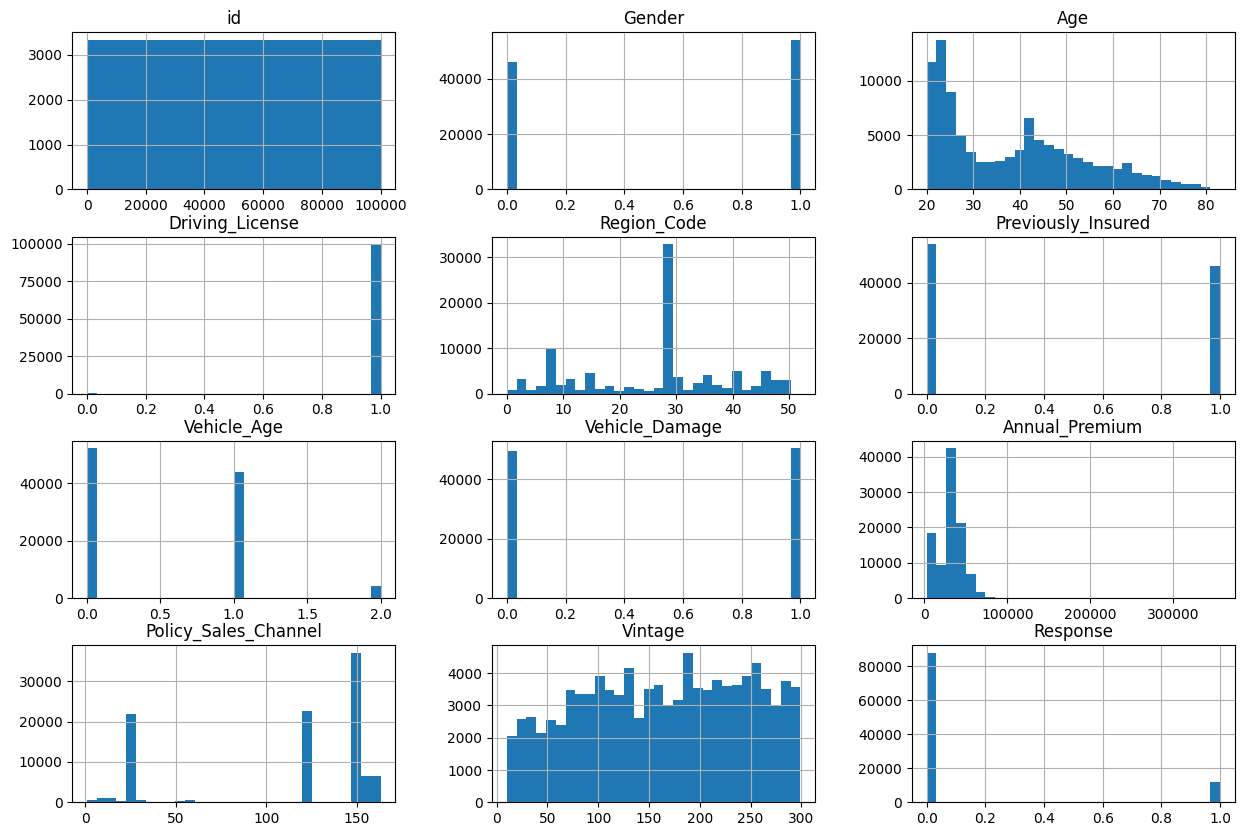

In [18]:
# Histogram
ds_train.hist(bins=30, figsize=(15, 10))

In [19]:
# Description
pd.set_option('display.float_format', lambda x: '%.0f' % x)
ds_train.describe()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
mean,50000,1,38,1,26,0,1,1,30403,112,164,0
std,28868,0,15,0,13,0,1,0,16251,54,80,0
min,0,0,20,0,0,0,0,0,2630,1,10,0
25%,25000,0,24,1,15,0,0,0,25208,29,98,0
50%,50000,1,36,1,28,0,0,1,31777,148,166,0
75%,74999,1,49,1,35,1,1,1,39490,152,232,0
max,99999,1,83,1,52,1,2,1,356577,163,299,1


### 3.4 Outlier Detection

Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. 
The presence of outliers can often skew results which take into consideration these data points. 
There are many "rules of thumb" for what constitutes an outlier in a dataset. 
Here, we will use Tukey''s Method for identfying outliers: An outlier step is calculated as 1.5 times the interquartile range (IQR). 
A data point with a feature that is beyond an outlier step outside of the IQR (interquartile range) for that feature is considered abnormal.

We will
* Assign the value of the 25th percentile for the given feature to Q1. 
* Assign the value of the 75th percentile for the given feature to Q3. 
* Assign the calculation of an outlier step for the given feature to step.
* Optionally remove data points from the dataset by adding indices to the outliers list.

#### Outlier Detection - IQR

In [20]:
outlier_features=['Age', 'Annual_Premium', 'Vintage']
all_outliers_index = []

# For each feature find the data points with extreme high or low values
for feature in outlier_features: #ds_train.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(ds_train[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(ds_train[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    outlier_rows = ds_train[~((ds_train[feature] >= Q1 - step) & (ds_train[feature] <= Q3 + step))]
    #display(outlier_rows)  
    
    print('Number of outliers:', len(outlier_rows), ' for ', feature)
    
    all_outliers_index.append(list(outlier_rows.index))

Number of outliers: 0  for  Age
Number of outliers: 20635  for  Annual_Premium
Number of outliers: 0  for  Vintage


In [21]:
# Select the indices for data points to remove
# I don't want to remove 


#### Outlier Detection - Z-Score

In [22]:
#from scipy import stats

#z_scores = np.abs(stats.zscore(data))
#data = data[(z_scores < 3).all(axis=1)]

### 3.5 Transforming Skewed Continuous Features

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of 
vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform 
if the range is not properly normalized. With the census dataset two features fit this description. 
Now we explore if any feature is skewed.

In [23]:
# Log-transform the skewed features
skewed = ['Annual_Premium']
ds_train[skewed] = ds_train[skewed].apply(lambda x: np.log(x + 1))

'''
skewed_features = data.select_dtypes(include=['float64', 'int64']).apply(lambda x: x.skew()).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_features})

# Log transform for skewed features
for feature in skewness[abs(skewness) > 0.5].index:
    data[feature] = np.log1p(data[feature])
'''

"\nskewed_features = data.select_dtypes(include=['float64', 'int64']).apply(lambda x: x.skew()).sort_values(ascending=False)\nskewness = pd.DataFrame({'Skew': skewed_features})\n\n# Log transform for skewed features\nfor feature in skewness[abs(skewness) > 0.5].index:\n    data[feature] = np.log1p(data[feature])\n"

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Driving_License'}>,
        <Axes: title={'center': 'Region_Code'}>,
        <Axes: title={'center': 'Previously_Insured'}>],
       [<Axes: title={'center': 'Vehicle_Age'}>,
        <Axes: title={'center': 'Vehicle_Damage'}>,
        <Axes: title={'center': 'Annual_Premium'}>],
       [<Axes: title={'center': 'Policy_Sales_Channel'}>,
        <Axes: title={'center': 'Vintage'}>,
        <Axes: title={'center': 'Response'}>]], dtype=object)

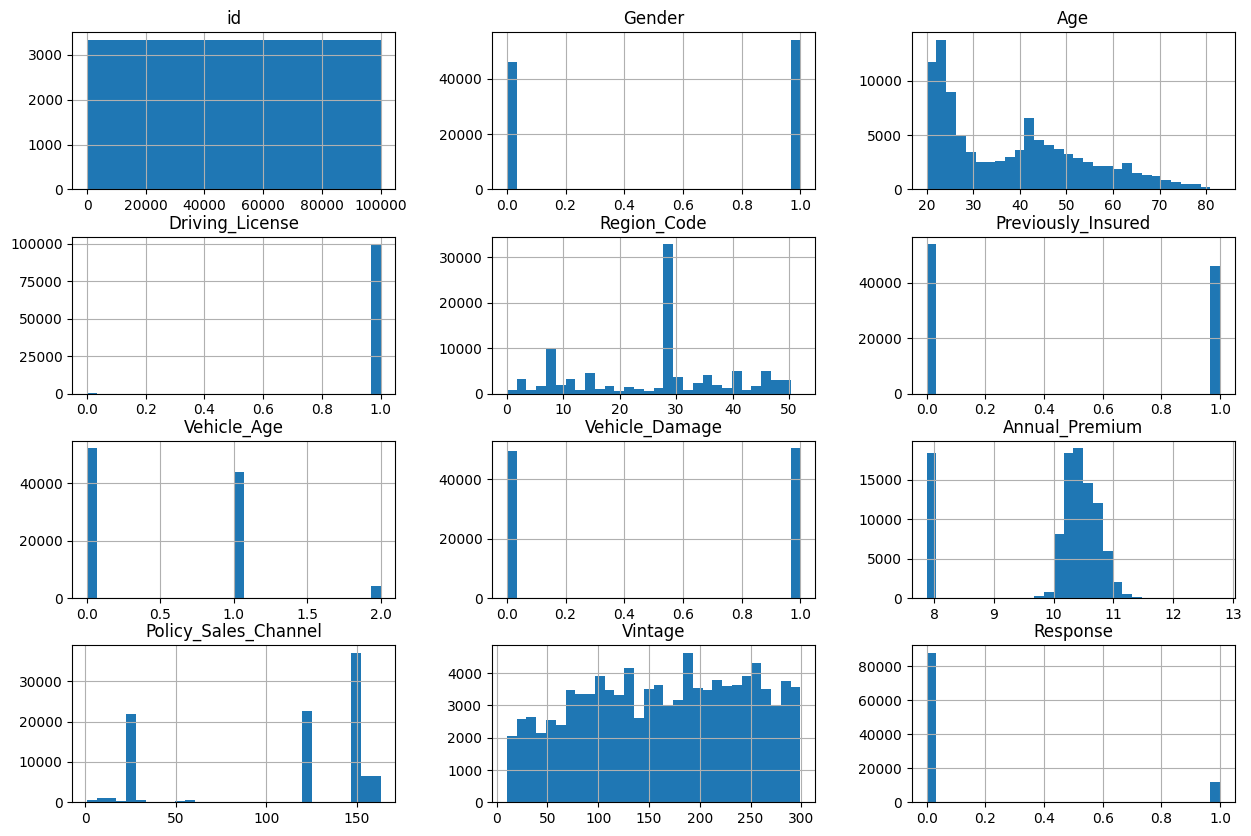

In [24]:
ds_train.hist(bins=30, figsize=(15, 10))
 

#### 3.6 Scaling Numeric Values
We will apply a scaling to the data does not change the shape of each feature's distribution; 
however, normalization ensures that each feature is treated equally when applying supervised learners. 

In [25]:
# Age would be an option but will try none first
numerical = []

# Initialize a scaler, then apply it to the features
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min

scaler = MinMaxScaler() # default=(0, 1)
ds_train[numerical] = ds_train[numerical].apply(lambda x: np.log(x + 1))

'''
scaler = StandardScaler()
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_features] = scaler.fit_transform(data[numeric_features])
'''


"\nscaler = StandardScaler()\nnumeric_features = data.select_dtypes(include=['float64', 'int64']).columns\ndata[numeric_features] = scaler.fit_transform(data[numeric_features])\n"

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Driving_License'}>,
        <Axes: title={'center': 'Region_Code'}>,
        <Axes: title={'center': 'Previously_Insured'}>],
       [<Axes: title={'center': 'Vehicle_Age'}>,
        <Axes: title={'center': 'Vehicle_Damage'}>,
        <Axes: title={'center': 'Annual_Premium'}>],
       [<Axes: title={'center': 'Policy_Sales_Channel'}>,
        <Axes: title={'center': 'Vintage'}>,
        <Axes: title={'center': 'Response'}>]], dtype=object)

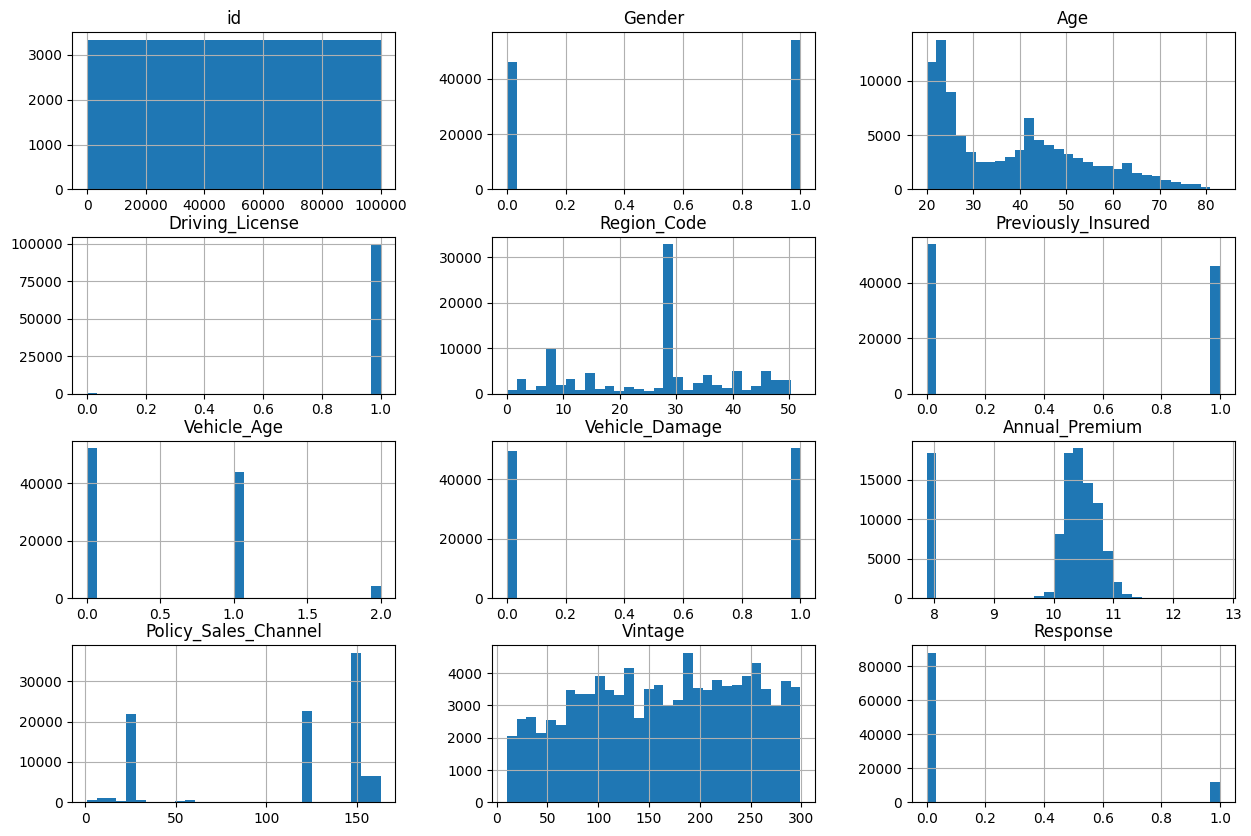

In [26]:
ds_train.hist(bins=30, figsize=(15, 10))

#### 3.7 Analysis by sample
We will apply a scaling to the data does not change the shape of each feature's distribution; 
however, normalization ensures that eac

In [27]:
ds_train.groupby(['Driving_License']).size()

Driving_License
0      178
1    99822
dtype: int64

In [28]:
ds_train.groupby(['Driving_License', 'Response']).size()

Driving_License  Response
0                0             173
                 1               5
1                0           87677
                 1           12145
dtype: int64

In [29]:
ds_train.groupby(['Age', 'Response']).size()

Age  Response
20   0           1492
     1             39
21   0           4228
     1            127
22   0           5594
                 ... 
79   1             13
80   0            101
     1              3
81   0              1
83   1              1
Length: 124, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='Age', ylabel='Count'>

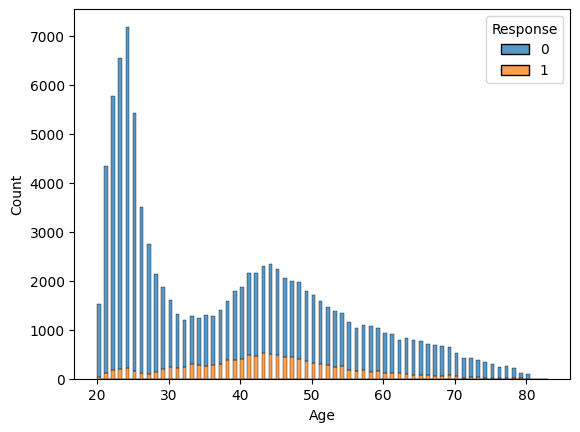

In [30]:
sns.histplot(binwidth=0.5, x="Age", hue="Response", data=ds_train, stat="count", multiple="stack")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='Annual_Premium', ylabel='Count'>

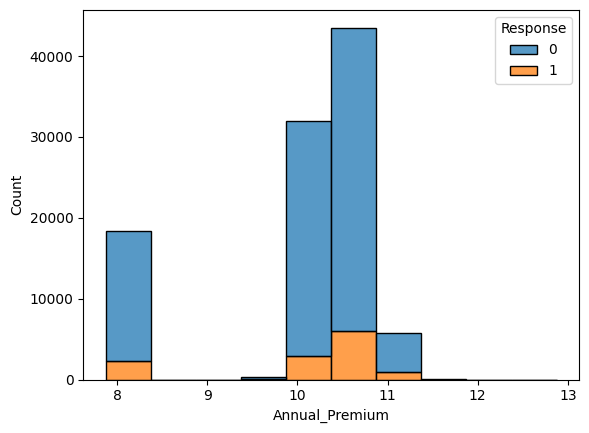

In [31]:
sns.histplot(binwidth=0.5, x="Annual_Premium", hue="Response", data=ds_train, stat="count", multiple="stack")

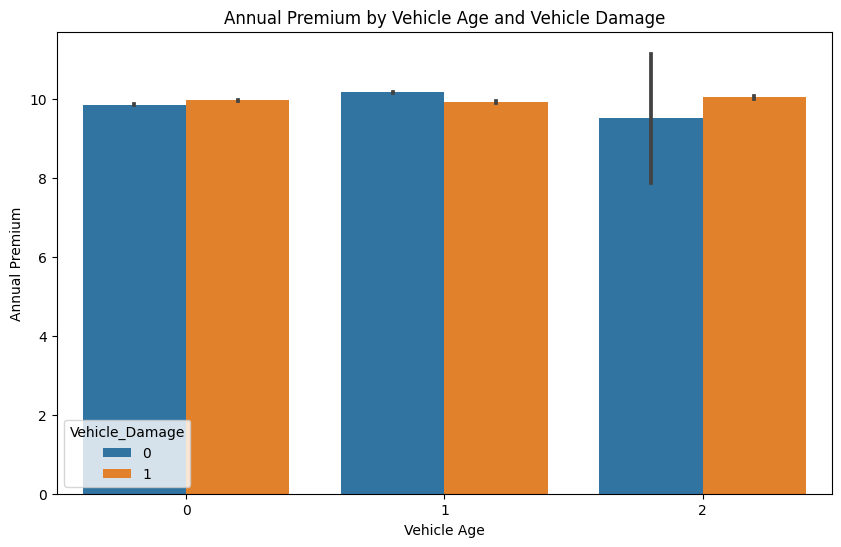

In [33]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Vehicle_Age', y='Annual_Premium', hue='Vehicle_Damage', data=ds_train)
plt.title('Annual Premium by Vehicle Age and Vehicle Damage')
plt.xlabel('Vehicle Age')
plt.ylabel('Annual Premium')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='Vintage', ylabel='Count'>

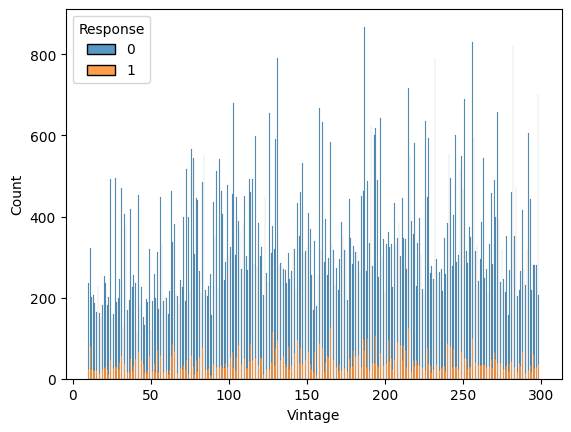

In [34]:
sns.histplot(binwidth=0.5, x="Vintage", hue="Response", data=ds_train, stat="count", multiple="stack")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='Policy_Sales_Channel', ylabel='Count'>

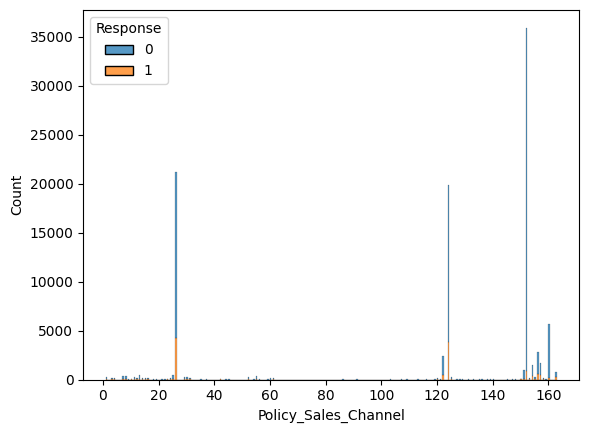

In [35]:
sns.histplot(binwidth=0.5, x="Policy_Sales_Channel", hue="Response", data=ds_train, stat="count", multiple="stack")

   Policy_Sales_Channel  count_of_response_0  count_of_response_1
0                   152                35062                  882
1                    26                16917                 4284
2                   124                15965                 3855
3                   160                 5524                  120
4                   156                 2295                  531
5                   122                 1985                  429
6                   157                 1254                  450
7                   154                 1103                  365
8                   151                  958                   28
9                   163                  532                  236


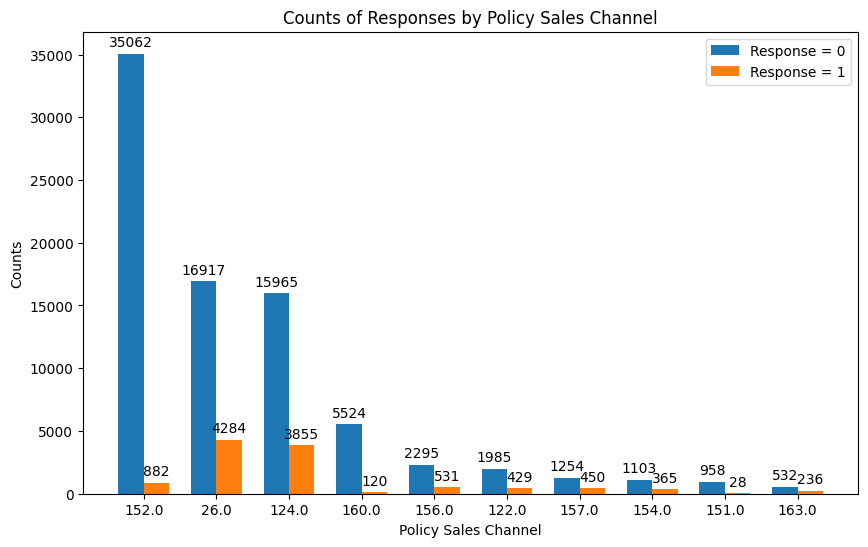

In [36]:
# Step 1: Group by 'Policy_Sales_Channel' and get counts
temp_df = ds_train.groupby(['Policy_Sales_Channel']).size().reset_index(name='Count_of_Sales')

# Step 2: Sort the DataFrame by 'count_of_sales' in descending order
temp_df = temp_df.sort_values(by='Count_of_Sales', ascending=False)

# Step 3: Filter the top 10 'Policy_Sales_Channel'
top_10_policy_sales_channels = temp_df.head(10)['Policy_Sales_Channel']

# Step 4: Calculate count of Response=0 and Response=1 for the top 10 'Policy_Sales_Channel'
response_counts = ds_train[ds_train['Policy_Sales_Channel'].isin(top_10_policy_sales_channels)].groupby(['Policy_Sales_Channel', 'Response']).size().unstack(fill_value=0)

# Step 5: Create the final DataFrame
final_df = response_counts.reindex(top_10_policy_sales_channels).reset_index()
final_df.columns = ['Policy_Sales_Channel', 'count_of_response_0', 'count_of_response_1']

print(final_df)

# Visualization

# Grouped Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define the position of the bars on the x-axis
ind = np.arange(len(final_df))  
width = 0.35  # Width of the bars

# Plotting the bars
bar1 = ax.bar(ind - width/2, final_df['count_of_response_0'], width, label='Response = 0')
bar2 = ax.bar(ind + width/2, final_df['count_of_response_1'], width, label='Response = 1')

# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Policy Sales Channel')
ax.set_ylabel('Counts')
ax.set_title('Counts of Responses by Policy Sales Channel')
ax.set_xticks(ind)
ax.set_xticklabels(final_df['Policy_Sales_Channel'])
ax.legend()

# Adding the counts above the bars
for bar in bar1:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bar2:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

In [ ]:
df_train_sample = df_train[:10000]

plt.figure(figsize=(12, 8))
sns.pairplot(df_train_sample[['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']], hue='Response', palette='viridis')
plt.title('Pair Plot')
plt.show()

## 4. Feature Relevance
One interesting thought to consider is if each feature is actually relevant for understanding reponse data. We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

We will 
* assign a copy of train data by removing a feature of our choice and
* use sklearn.cross_validation.train_test_split to split the dataset into training and testing sets
* use the removed feature as your target label. Set a test_size of 0.25 and set a random_state
* import a decision tree regressor, set a random_state, and fit the learner to the training data
* report the prediction score of the testing set using the regressor's score function.

The coefficient of determination, R^2, is scored between 0 and 1, with 1 being a perfect fit. 
A negative R^2 implies the model fails to fit the data. If you get a low score for a particular feature, that lends us to beleive that that feature point is hard to predict using the other features, thereby making it an important feature to consider when considering relevance.

In [37]:
for feature in feature_names:  
    # make a copy of date frame and drop a given feature
    new_data = ds_train.drop([feature], axis=1)
    
    # Split the data into training and testing sets(0.25) using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(new_data, ds_train[feature], test_size=0.25, random_state=103)
    
    # Create a decision tree regressor and fit it to the training set
    regressor = tree.DecisionTreeRegressor(random_state=103)
    regressor.fit(X_train, y_train)
    score = regressor.score(X_test, y_test)
    
    # Report the score of the prediction using the testing set
    print(feature, round(score,2))

id -1.07
Gender -0.91
Age 0.38
Driving_License -1.38
Region_Code -0.95
Previously_Insured 0.45
Vehicle_Age 0.04
Vehicle_Damage 0.46
Annual_Premium -0.29
Policy_Sales_Channel -0.13
Vintage -1.06


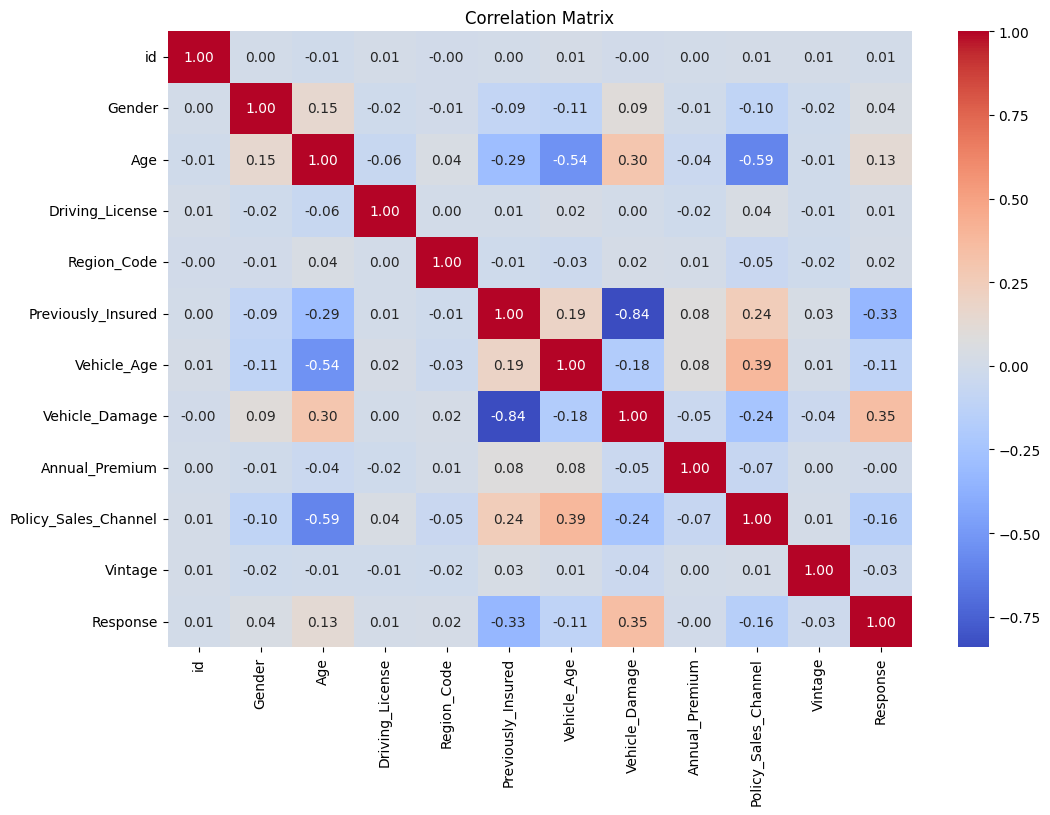

In [38]:
corr_matrix = ds_train.head(10000).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [39]:
corr_matrix

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,1,0,-0,0,-0,0,0,-0,0,0,0,0
Gender,0,1,0,-0,-0,-0,-0,0,-0,-0,-0,0
Age,-0,0,1,-0,0,-0,-1,0,-0,-1,-0,0
Driving_License,0,-0,-0,1,0,0,0,0,-0,0,-0,0
Region_Code,-0,-0,0,0,1,-0,-0,0,0,-0,-0,0
Previously_Insured,0,-0,-0,0,-0,1,0,-1,0,0,0,-0
Vehicle_Age,0,-0,-1,0,-0,0,1,-0,0,0,0,-0
Vehicle_Damage,-0,0,0,0,0,-1,-0,1,-0,-0,-0,0
Annual_Premium,0,-0,-0,-0,0,0,0,-0,1,-0,0,-0
Policy_Sales_Channel,0,-0,-1,0,-0,0,0,-0,-0,1,0,-0


Conclusions:
- Response has the highest positive correlation with Vehicle_Damage. Customers who have had vehicle damage are more likely to respond positively.
- Previously_Insured has a moderate negative correlation with Respons, suggesting that customers who were previously insured are less likely to respond positively.
- Policy_Sales_Channel has a weak positive correlation with Vehicle_Age and a moderate negative correlation with Age. Different sales channels may be used for different age groups and vehicle ages.

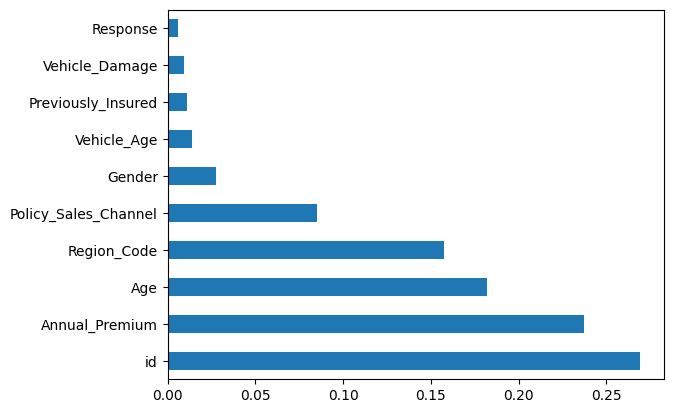

In [40]:
# Feature importance using a model
model = RandomForestClassifier()
model.fit(X_train.head(10000), y_train.head(10000))
importances = model.feature_importances_

# Plotting feature importances
feat_importances = pd.Series(importances, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## 5. Visualize Feature Distributions

To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. 
If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below 
may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying 
a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. 

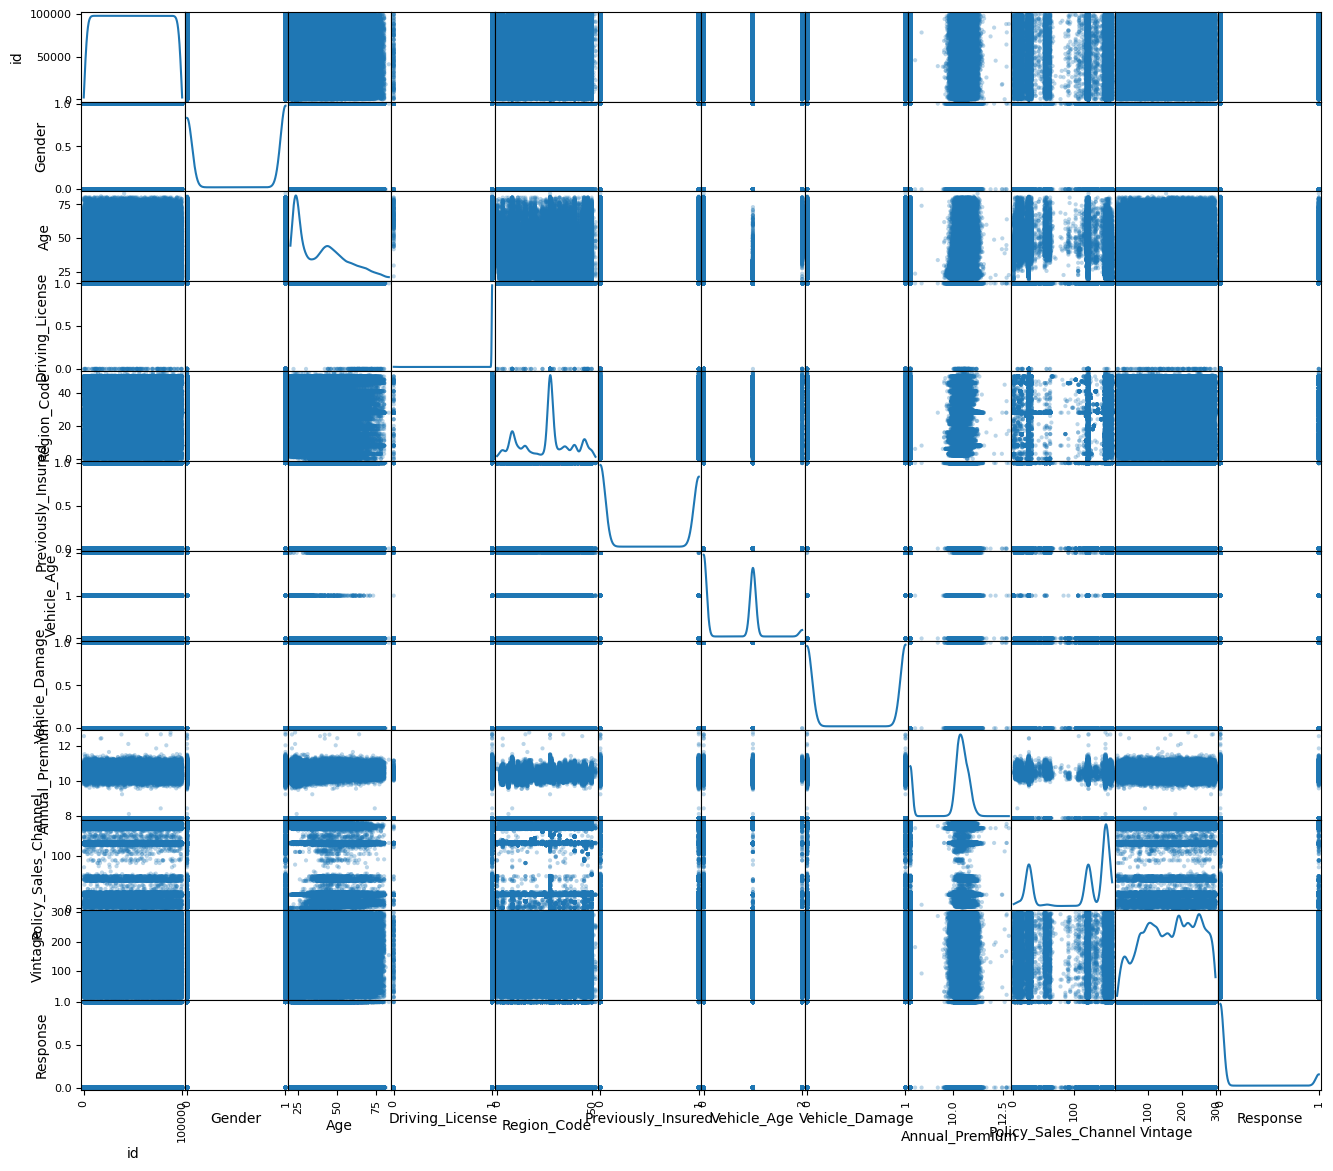

In [41]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(ds_train, alpha = 0.3, figsize = (16,14), diagonal = 'kde');


## 6.Shuffle and Split Data

We will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.
t.

In [42]:
# Import train_test_split
X = ds_train.drop(columns=[predict])
y = ds_train[predict]

# Split the 'features' and <predict> data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Handling Imbalanced Data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Show the results of the split
print('Training set has ', format(X_train.shape[0]), ' samples.');
print('Test set has ', format(X_test.shape[0]), ' samples.');

Training set has  140514  samples.
Test set has  20000  samples.


## 7. Evaluating Model Performance

### 7.1 Naive Predictor

In [43]:
# Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
# encoded to numerical values done in the data preprocessing step.
TP = sum(y)

# Specific to the naive case
FP = len(y)- TP

# No predicted negatives in the naive case
TN = 0 
FN = 0

# accuracy, precision and recall

accuracy = float(TP) / (TP+FP)
recall = float(TP) / (TP+FN)
precision = float(TP) / (TP+FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (float) (1+0.5*0.5)*((precision*recall)/((0.5*0.5*precision)+recall))

# Print the results 
print('Naive Predictor: [Accuracy score: ', accuracy, ' F-score: ',  fscore);


Naive Predictor: [Accuracy score:  0.1215  F-score:  0.14739779206599538


### 7.2 Compare Models

In [44]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = dt.time() # Get start time
    learner = learner.fit(X_train[1:sample_size], y_train[1:sample_size])
    end = dt.time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
    
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = dt.time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[1:300])
    end = dt.time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
    
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[1:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[1:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    
    #Success
    print(learner.__class__.__name__ , ' trained on ', sample_size, ' samples.')
    
    # Return the results
    return results

In [45]:
# Initialize the three models
clf_A = DecisionTreeClassifier(random_state = 0)#Decision Tree Classifier
#clf_B = SVC(random_state = 0)#Support Vector Classification
clf_B = RandomForestClassifier(random_state = 0)
clf_C = LogisticRegression(random_state = 0)#Support Vector Classification

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100
# HINT: samples_1 is 1% of samples_100
size_of_train_data = len(X_train)
samples_100 = size_of_train_data
samples_10  = int(size_of_train_data*0.1)
samples_1   = int(size_of_train_data*0.01)

# If accuracy, f-score and time are printed in the function
# print "Algorith-Sample Size-Test Accuracy-Test FScore-Train Accuracy-Train FScore-Train Time-Prediction Time"  
    
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

DecisionTreeClassifier  trained on  1405  samples.
DecisionTreeClassifier  trained on  14051  samples.
DecisionTreeClassifier  trained on  140514  samples.
RandomForestClassifier  trained on  1405  samples.
RandomForestClassifier  trained on  14051  samples.
RandomForestClassifier  trained on  140514  samples.
LogisticRegression  trained on  1405  samples.
LogisticRegression  trained on  14051  samples.
LogisticRegression  trained on  140514  samples.


In [46]:
def evaluate(results, accuracy, f1):
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (12,10))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']

    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):                
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):           
            for i in np.arange(3): 
                xcor = int(j/3)
                ycor = int(j%3)                
                ax[xcor, ycor].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])                
                ax[xcor, ycor].set_xticks([0.45, 1.45, 2.45])
                ax[xcor, ycor].set_xticklabels(["1%", "10%", "100%"])
                ax[xcor, ycor].set_xlabel("Training Set Size")
                ax[xcor, ycor].set_xlim((-0.1, 3.0))
                
                
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
   
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_33/1954538922.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


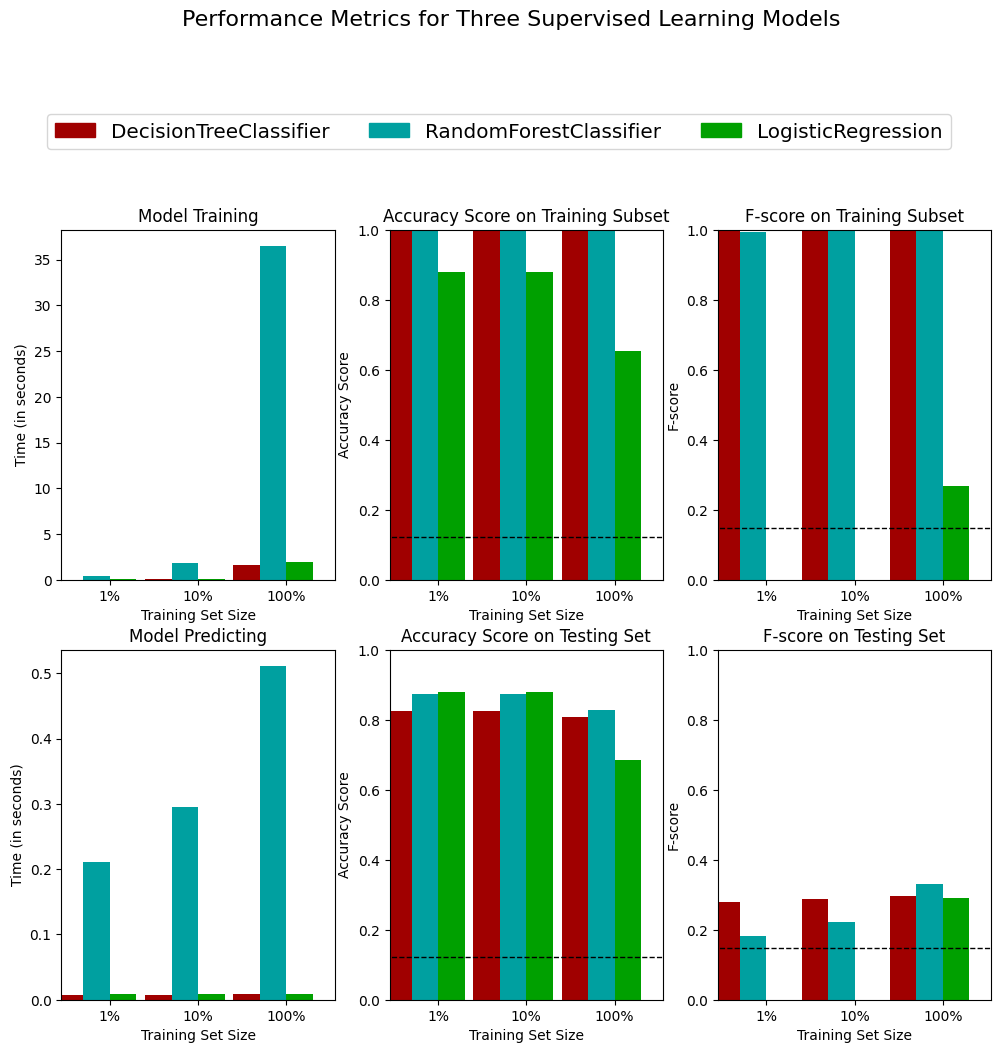

In [47]:
evaluate(results, accuracy, fscore)

### 7.3 Improving Models - DecisionTreeClassifier

In [48]:
tree_clas = DecisionTreeClassifier(random_state=1024)

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy'],
              'max_features' :['sqrt']
             }
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)

final_model = grid_search.best_estimator_
final_model

Fitting 5 folds for each of 30 candidates, totalling 150 fits


DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=9,
                       max_features='sqrt', random_state=1024)

In [49]:
# unoptimized 
predictions = (tree_clas.fit(X_train, y_train)).predict(X_test)

#optimized
tree_clas = DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=9,
                       max_features='sqrt', random_state=1024)

best_predictions = (tree_clas.fit(X_train, y_train)).predict(X_test)

# Report the before-and-afterscores
print('Unoptimized model\n------')
print('Accuracy score on testing data: ', accuracy_score(y_test, predictions))
print('F-score on testing data: ', fbeta_score(y_test, predictions, beta = 0.5))
print('\nOptimized Model\n------')
print('Final accuracy score on the testing data: ', accuracy_score(y_test, best_predictions))
print('Final F-score on the testing data: ', fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data:  0.80475
F-score on testing data:  0.2913886240864315

Optimized Model
------
Final accuracy score on the testing data:  0.7681
Final F-score on the testing data:  0.3334568358651353


### 7.4 Improving Models - RandomForestClassifier

In [ ]:
rand_clas = RandomForestClassifier(random_state=1024)

param_grid = {'bootstrap': [True, False],
              'max_depth': [10, 100],
              'min_samples_leaf': [1, 4],
              'min_samples_split': [2, 10],
              'n_estimators': [200, 1000],
              'max_features' :['sqrt']}

grid_search = GridSearchCV(estimator=rand_clas, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)

final_model = grid_search.best_estimator_
final_model

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [ ]:
# unoptimized 
predictions = (rand_clas.fit(X_train, y_train)).predict(X_test)

#optimized
rand_clas = RandomForestClassifier()

best_predictions = (rand_clas.fit(X_train, y_train)).predict(X_test)

# Report the before-and-afterscores
print('Unoptimized model\n------')
print('Accuracy score on testing data: ', accuracy_score(y_test, predictions))
print('F-score on testing data: ', fbeta_score(y_test, predictions, beta = 0.5))
print('\nOptimized Model\n------')
print('Final accuracy score on the testing data: ', accuracy_score(y_test, best_predictions))
print('Final F-score on the testing data: ', fbeta_score(y_test, best_predictions, beta = 0.5))

### 7.5 Improving Models - LogisticRegression

In [ ]:
log_clas = LogisticRegression(random_state=1024)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1'],
              'max_iter': list(range(100,800,100)),
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],              
              'max_features' :['sqrt']}

grid_search = GridSearchCV(estimator=log_clas, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)

final_model = grid_search.best_estimator_
final_model

In [ ]:
# unoptimized 
predictions = (log_clas.fit(X_train, y_train)).predict(X_test)

#optimized
log_clas = LogisticRegression()

best_predictions = (log_clas.fit(X_train, y_train)).predict(X_test)

# Report the before-and-afterscores
print('Unoptimized model\n------')
print('Accuracy score on testing data: ', accuracy_score(y_test, predictions))
print('F-score on testing data: ', fbeta_score(y_test, predictions, beta = 0.5))
print('\nOptimized Model\n------')
print('Final accuracy score on the testing data: ', accuracy_score(y_test, best_predictions))
print('Final F-score on the testing data: ', fbeta_score(y_test, best_predictions, beta = 0.5))

### 7.7 Feature Importance

In [ ]:
# Extract the feature importances using .feature_importances_ 
importances = tree_clas.feature_importances_

# Plot
va.feature_plot(importances, X_train, y_train)

### 7.8 Feature Selection

In [ ]:
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(tree_clas)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print('Final Model trained on full data\n------')
print('Accuracy score on testing data: ', accuracy_score(y_test, best_predictions))
print('F-score on testing data: ', fbeta_score(y_test, best_predictions, beta = 0.5))
print('\nFinal Model trained on reduced data\n------')
print('Final accuracy score on the testing data: ', accuracy_score(y_test, reduced_predictions))
print('Final F-score on the testing data: ', fbeta_score(y_test, reduced_predictions, beta = 0.5))

## 8. Get Final Data

In [ ]:
# Writing to Submission file
ds_final=pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
ds_final.Id=ds_test['id']
ds_final.Response= ds_test['

ds_final.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')